In [1]:
import findspark
findspark.init()
import pyspark

from pyspark.sql import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from helper import load_countries, join_countries

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
DATA_PATH = "../../data/"

# External datasets

We first need to load the datasets we will use to compute the correlations. As mentionned in the [README](https://github.com/damlobster/ada2018#external-datasets), we have chosen to check for correlations of the ratio and the tone of each countries with their respectives Human development index, Environmental performance index and Gross Domestic Product per capita.

We first need to load the mapping between the differents countries codes standards (ie. FIPS, ISO2, ISO3).

In [4]:
countries = pd.read_csv(DATA_PATH + "local_generated/preprocessed_countries.csv")
countries.Country = countries.Country.astype(str).str.strip()
countries["ISO"] = countries.ISO2
#countries.set_index("ISO", inplace=True)
countries.head(5)

,Country,Region,FIPS,ISO2,ISO3,ISO
0,Afghanistan,Asia,AF,AF,AFG,AF
1,Albania,Europe,AL,AL,ALB,AL
2,Algeria,Africa,AG,DZ,DZA,DZ
3,American Samoa,Oceania,AQ,AS,ASM,AS
4,Andorra,Europe,AN,AD,AND,AD


### Human development index ([source](http://hdr.undp.org/en/content/human-development-index-hdi))

The Human Development Index (HDI) is a statistic composite index of life expectancy, education, and per capita income indicators, which are used to rank countries into four tiers of human development.

In [5]:
hdi = pd.read_csv(DATA_PATH + "external_datasets/human_development_index_2017.csv")
hdi.head(5)

,HDI Rank,Country,ISO3,2015,2016,2017
0,168,Afghanistan,AFG,0.493,0.494,0.498
1,68,Albania,ALB,0.776,0.782,0.785
2,85,Algeria,DZA,0.749,0.753,0.754
3,35,Andorra,AND,0.854,0.856,0.858
4,147,Angola,AGO,0.572,0.577,0.581


In [6]:
hdi = hdi.set_index("ISO3")[["2017"]]
hdi.rename(columns={"2017":"hdi_2017"}, inplace=True)
hdi.head(5)

,hdi_2017
ISO3,
AFG,0.498
ALB,0.785
DZA,0.754
AND,0.858
AGO,0.581


### Environmental performance index ([source](https://epi.envirocenter.yale.edu/epi-downloads))

The Environmental Performance Index (EPI) is a method of quantifying and numerically marking the environmental performance of a state's policies. 

In [7]:
epi = pd.read_csv(DATA_PATH + "external_datasets/epi2018countrysnapshotv01.csv")
epi.head(5)

,code,iso,country,Pop,PopGrowthRate,PopDensity,GDP,LandArea,GDPpc,SDGI,EPI2018Score,EPI2018Rank
0,4,AFG,Afghanistan,34.656032,2.689163,53.083405,60.287050,652860.0,1739.583177,46.8,37.74,168
1,8,ALB,Albania,2.876101,-0.159880,104.967190,32.669916,27400.0,11359.099160,68.9,65.46,40
2,12,DZA,Algeria,40.606052,1.825463,17.048895,565.284000,2381741.0,13921.176080,68.8,57.18,88
3,24,AGO,Angola,28.813463,3.367572,23.111786,172.438000,1246700.0,5984.632947,50.2,37.44,170
4,28,ATG,Antigua and Barbuda,0.100963,1.035422,229.461364,2.121537,440.0,21013.017630,NaN,59.18,76


In [8]:
epi = epi[["iso", "country", "GDPpc", "EPI2018Score"]]
epi = epi.set_index("iso")
epi.head(5)

,country,GDPpc,EPI2018Score
iso,,,
AFG,Afghanistan,1739.583177,37.74
ALB,Albania,11359.099160,65.46
DZA,Algeria,13921.176080,57.18
AGO,Angola,5984.632947,37.44
ATG,Antigua and Barbuda,21013.017630,59.18


In [9]:
external_data = hdi.join(epi).join(countries.set_index("ISO3")[["ISO2", "Region"]])
external_data.head(5)

,hdi_2017,country,GDPpc,EPI2018Score,ISO2,Region
ISO3,,,,,,
AFG,0.498,Afghanistan,1739.583177,37.74,AF,Asia
AGO,0.581,Angola,5984.632947,37.44,AO,Africa
ALB,0.785,Albania,11359.099160,65.46,AL,Europe
AND,0.858,NaN,NaN,NaN,AD,Europe
ARE,0.863,United Arab Emirates,67133.014840,58.90,AE,Asia


# Plot linear regressions

In [22]:
def plot_worldwide(data, feature, title, robust):
    plt.figure(figsize=(18,6))
    plt.suptitle(title)
    plt.subplot(131, title="Human development index")
    _ = sns.regplot("hdi_2017", feature, data, ci=95, robust=robust, scatter_kws={'alpha':0.4})
    plt.subplot(132, title="Environmental performance index")
    _ = sns.regplot("EPI2018Score", feature, data, ci=95, robust=robust, scatter_kws={'alpha':0.4})
    plt.subplot(133, title="GDP per capita")
    _ = sns.regplot("GDPpc", feature, data, ci=95, robust=robust, scatter_kws={'alpha':0.4})

In [23]:
def plot_by_regions(data, feature, robust):
    lm = sns.lmplot(x="hdi_2017", y=feature, data=data, col="Region", ci=95, robust=robust, scatter_kws={'alpha':0.4})
    lm.fig.suptitle("Human development index", size=14)
    lm.fig.subplots_adjust(top=.9)
    lm = sns.lmplot(x="EPI2018Score", y=feature, data=data, col="Region", ci=95, robust=robust, scatter_kws={'alpha':0.4})
    lm.fig.suptitle("Environmental performance index", size=14)
    lm.fig.subplots_adjust(top=.9)
    lm = sns.lmplot(x="GDPpc", y=feature, data=data, col="Region", ci=95, robust=robust, scatter_kws={'alpha':0.4})
    lm.fig.suptitle("GDP per capita", size=14)
    lm.fig.subplots_adjust(top=.9)

### Mentions tones

In [24]:
# Read the parquet computed on the cluster and renamne columns
tones_df = spark.read.parquet(DATA_PATH + "from_cluster/tone_mentions_5themes_europe.parquet")
tones = tones_df.toPandas()
tones.columns = ["DAY","MONTH","YEAR","Tone","STATE"]
tones = join_countries(tones,countries,None, with_iso=True)
tones = tones.groupby("ISO").median()
tones.head()

,Tone
ISO,
AD,-1.749271
AE,-0.791868
AF,-2.797690
AG,-0.743615
AI,-1.381666


In [25]:
tones_joined = tones.join(external_data.set_index("ISO2", drop=True), how="left")
tones_joined = tones_joined[tones_joined.Region != "Oceania"]
tones_joined.dropna(inplace=True)
tones_joined.head(5)

,Tone,hdi_2017,country,GDPpc,EPI2018Score,Region
AE,-0.791868,0.863,United Arab Emirates,67133.014840,58.90,Asia
AF,-2.797690,0.498,Afghanistan,1739.583177,37.74,Asia
AG,-0.743615,0.780,Antigua and Barbuda,21013.017630,59.18,Americas
AL,-2.445430,0.785,Albania,11359.099160,65.46,Europe
AM,-1.443507,0.755,Armenia,8190.239289,62.07,Asia


In [26]:
robust = False

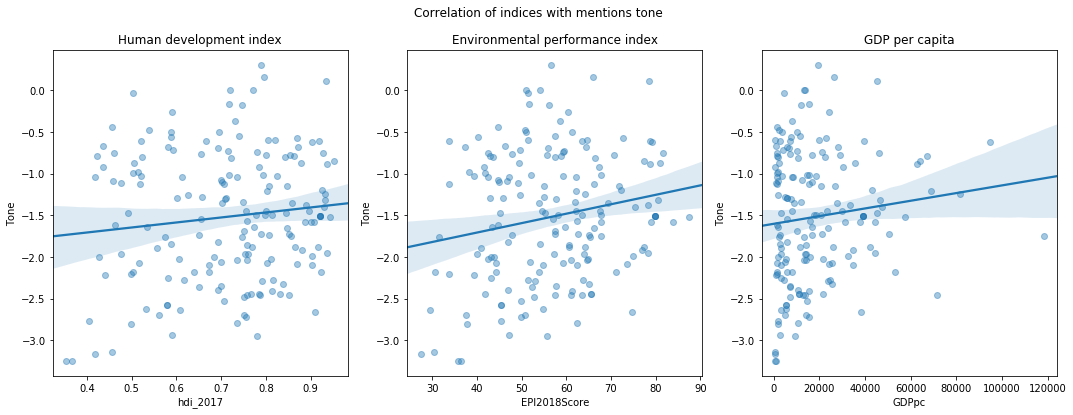

In [27]:
plot_worldwide(tones_joined, "Tone", "Correlation of indices with mentions tone", robust=robust)

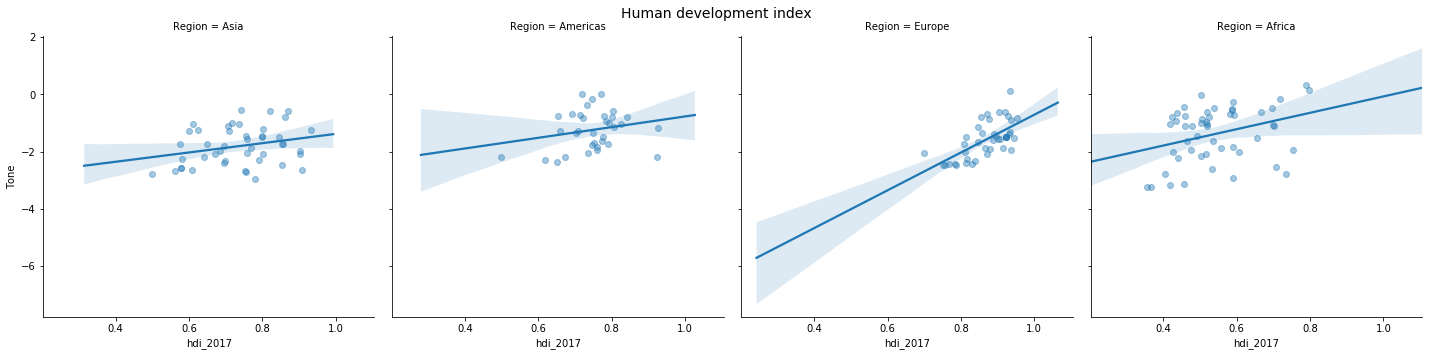

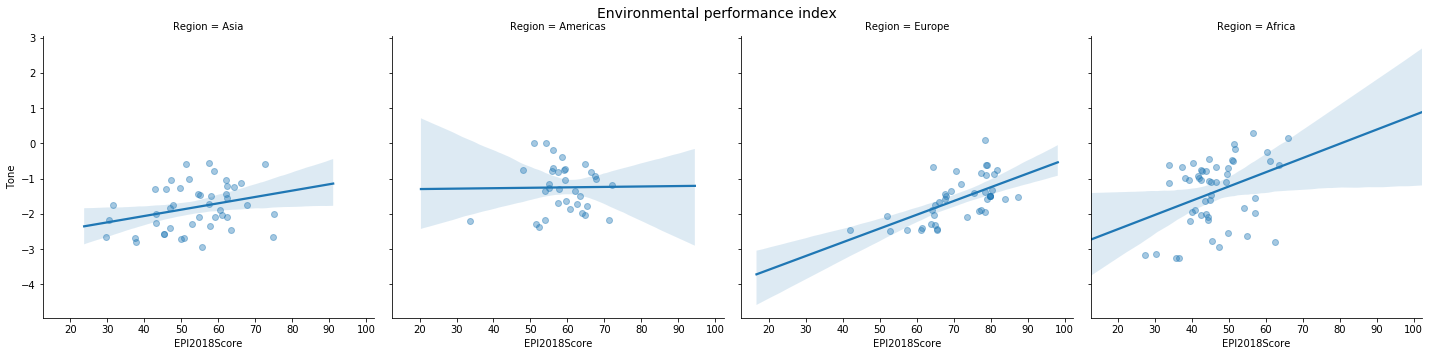

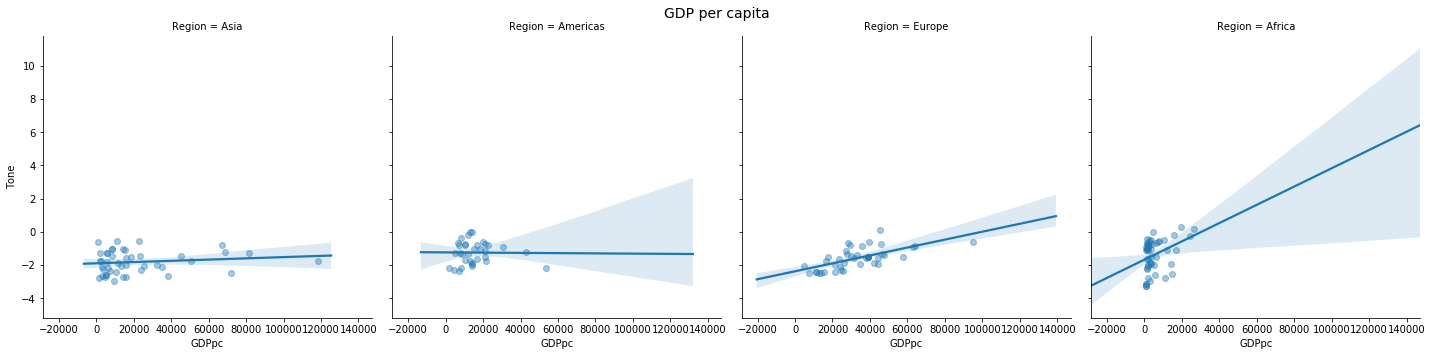

In [28]:
plot_by_regions(tones_joined, "Tone", robust=robust)

### Mentions ratios

Here we load the mentions ratios with the outliers removed (for details, see [mentions_counts_by_domain_locations.ipynb](../mentions_count/mentions_counts_by_domain_locations.ipynb)) and then we compute the mean ratio for each countries.

In [29]:
MENTIONS_COUNTS_FILE = DATA_PATH + "from_cluster/mentions_counts_by_state_and_days_filtered_5themes.csv"

In [30]:
mentions_ratios = pd.read_csv(MENTIONS_COUNTS_FILE)
mentions_ratios.dropna(inplace=True)
mentions_ratios = join_countries(mentions_ratios, countries, with_iso=True)
mentions_ratios = mentions_ratios.assign(Ratio=mentions_ratios.ENV_COUNT/mentions_ratios.GLOBAL_COUNT)
mentions_ratios = mentions_ratios.drop(columns=["ENV_COUNT", "GLOBAL_COUNT"])
mentions_ratios = mentions_ratios.groupby("ISO").median()
mentions_ratios.sample(5)

,Ratio
ISO,
MY,0.022451
CY,0.030612
GR,0.015062
RE,0.093750
KP,0.018762


In [31]:
ratios_joined = mentions_ratios.join(external_data.set_index("ISO2", drop=True), how="left")
ratios_joined = ratios_joined[ratios_joined.Region != "Oceania"]
ratios_joined.dropna(inplace=True)
ratios_joined.sample(5)

,Ratio,hdi_2017,country,GDPpc,EPI2018Score,Region
EC,0.052948,0.752,Ecuador,10424.247250,57.42,Americas
UA,0.039854,0.751,Ukraine,7270.693947,52.87,Europe
LB,0.010414,0.757,Lebanon,13267.885700,61.08,Asia
GR,0.015062,0.870,Greece,24277.594880,73.60,Europe
MY,0.022451,0.802,Malaysia,25668.874780,59.22,Asia


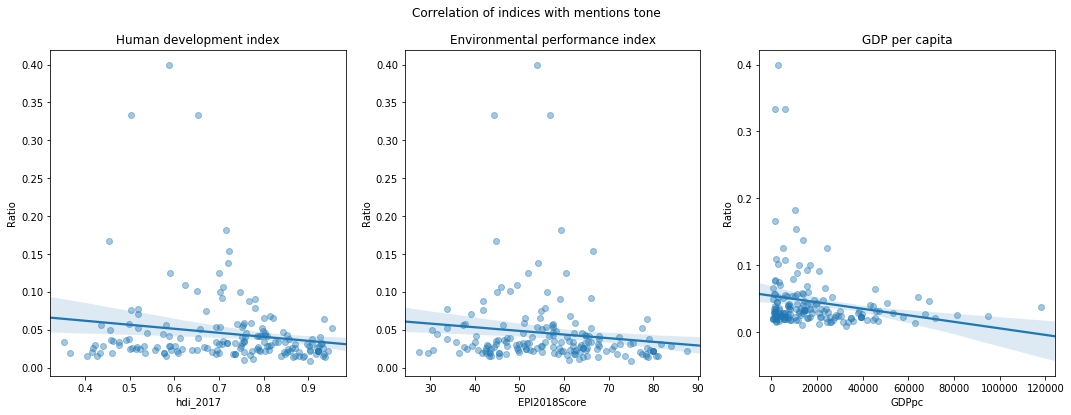

In [32]:
plot_worldwide(ratios_joined, "Ratio", "Correlation of indices with mentions tone", robust=robust)

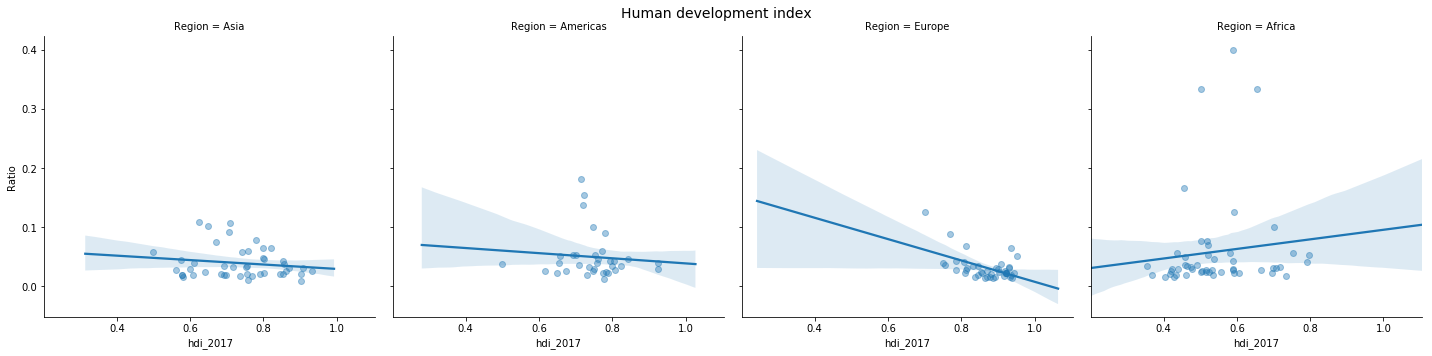

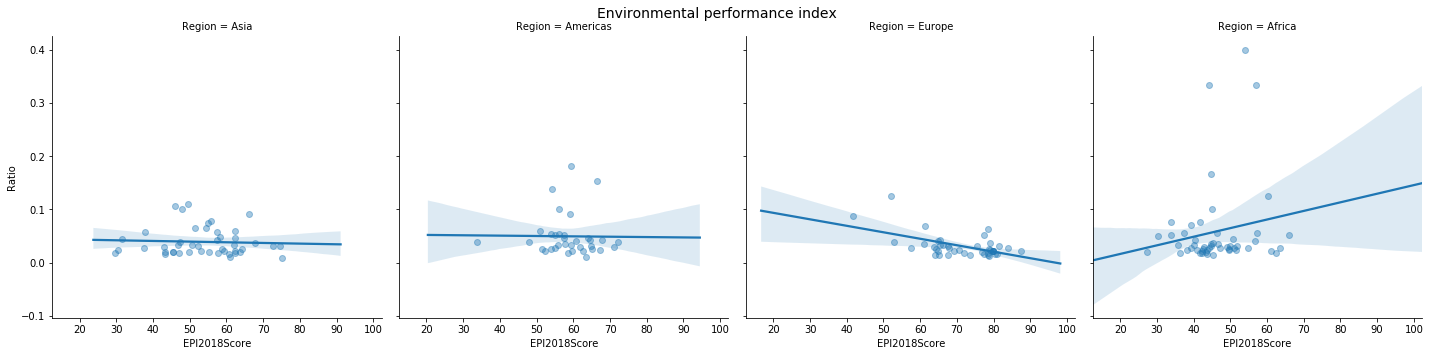

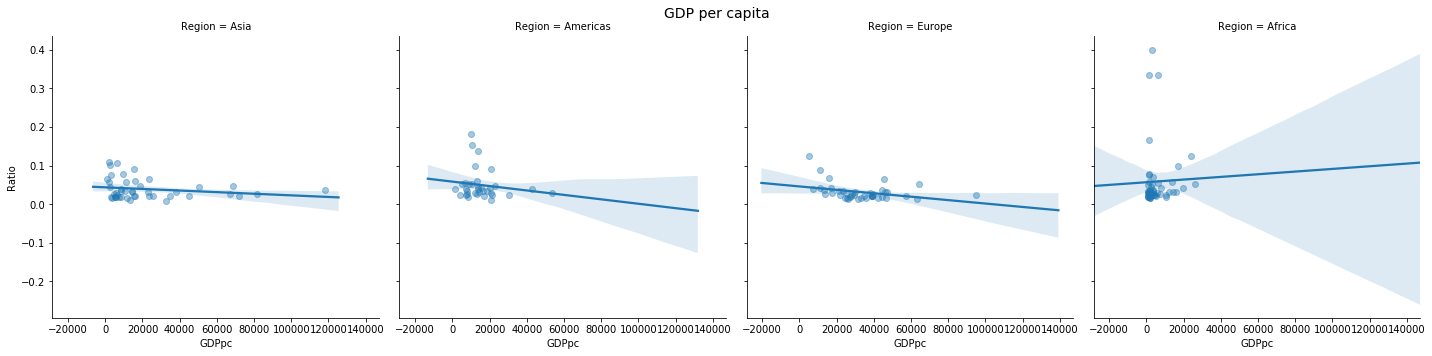

In [33]:
plot_by_regions(ratios_joined, "Ratio", robust=robust)